In [81]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')

In [3]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


<AxesSubplot:>

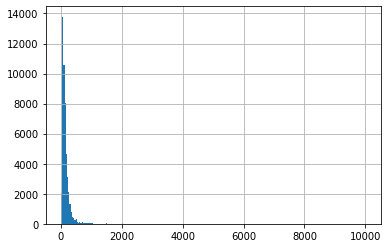

In [8]:
df['price'].hist(bins=250)

In [10]:
(df['price'] > 2000).sum()

86

In [12]:
df = df.filter(items=['latitude', 'longitude', 'price','minimum_nights', 'number_of_reviews', 
                      'reviews_per_month', 'calculated_host_listings_count', 'availability_365'])

### Question 1

In [14]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Column `reviews_per_month`. It has `10052` null values.

### Question 2

In [16]:
df['minimum_nights'].median()

3.0

The median is `3.0`.

### Question 3

Here the linear regression code used in the course and that should be used in the exercise.

In [61]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

We will however compare it with the sklearn linear regression.

In [93]:
def prepare_train_val_test_data(df, random_seed=42):
    shuffled_df = df.sample(frac=1, random_state=random_seed)
    X = shuffled_df.drop(columns=['price'])
    y = shuffled_df['price']
    
    X_train = X.iloc[0:int(len(df)*0.6)]
    X_val = X.iloc[int(len(df)*0.6):int(len(df)*0.8)]
    X_test = X.iloc[int(len(df)*0.8):len(df)]
    
    y_train = y.iloc[0:int(len(df)*0.6)]
    y_val = y.iloc[int(len(df)*0.6):int(len(df)*0.8)]
    y_test = y.iloc[int(len(df)*0.8):len(df)]
    y_train = np.log1p(y_train.values)
    y_val = np.log1p(y_val.values)
    y_test = np.log1p(y_test.values)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [94]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_train_val_test_data(df)

##### Fill NA with 0

In [95]:
def fill_na_with_0(X_train, X_val, X_test):
    X_train_0 = X_train.copy()
    X_train_0['reviews_per_month'] = X_train_0['reviews_per_month'].fillna(0)
    X_val_0 = X_val.copy()
    X_val_0['reviews_per_month'] = X_val_0['reviews_per_month'].fillna(0)
    X_test_0 = X_test.copy()
    X_test_0['reviews_per_month'] = X_test_0['reviews_per_month'].fillna(0)
    return X_train_0, X_val_0, X_test_0

In [96]:
X_train_0, X_val_0, X_test_0 = fill_na_with_0(X_train, X_val, X_test)

In [97]:
model_0 = linear_model.LinearRegression()
model_0.fit(X_train_0, y_train)
y_val_pred_0 = model_0.predict(X_val_0)
mse_0 = mean_squared_error(y_val, y_val_pred_0)
mse_0

0.41349244074288205

In [71]:
w0, w = train_linear_regression(X_train_0, y_train)
y_val_pred_0 = w0 + X_val_0.dot(w)
mse_0 = mean_squared_error(y_val, y_val_pred_0)
mse_0

0.41349244074217706

In [75]:
print(f'RMSE = {np.sqrt(mse_0):.2f}')

RMSE = 0.64


##### Fill NA with the mean value

In [99]:
def fill_na_with_mean(X_train, X_val, X_test):
    mean_reviews_per_month = X_train['reviews_per_month'].dropna().mean()

    X_train_mean = X_train.copy()
    X_train_mean['reviews_per_month'] = X_train_mean['reviews_per_month'].fillna(mean_reviews_per_month)

    X_val_mean = X_val.copy()
    X_val_mean['reviews_per_month'] = X_val_mean['reviews_per_month'].fillna(mean_reviews_per_month)

    X_test_mean = X_train.copy()
    X_test_mean['reviews_per_month'] = X_test_mean['reviews_per_month'].fillna(mean_reviews_per_month)
    
    return X_train_mean, X_val_mean, X_test_mean

In [100]:
X_train_mean, X_val_mean, X_test_mean = fill_na_with_mean(X_train, X_val, X_test)

In [101]:
model_mean = linear_model.LinearRegression()
model_mean.fit(X_train_mean, y_train)
y_val_pred_mean = model_mean.predict(X_val_mean)
mse_mean = mean_squared_error(y_val, y_val_pred_mean)
mse_mean

0.4131333513467101

In [73]:
w0, w = train_linear_regression(X_train_mean, y_train)
y_val_pred_mean = w0 + X_val_mean.dot(w)
mse_mean = mean_squared_error(y_val, y_val_pred_mean)
mse_mean

0.4131333513630601

In [76]:
print(f'RMSE = {np.sqrt(mse_mean):.2f}')

RMSE = 0.64


The two approaches result in the same score.

### Question 4

In [77]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [91]:
r_to_rmse_dict = dict()
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_reg(X_train_0, y_train, r=r)
    mse = mean_squared_error(y_val, w0 + X_val_0.dot(w))
    r_to_rmse_dict[r] = round(np.sqrt(mse), 2)

In [92]:
r_to_rmse_dict

{0: 0.64,
 1e-06: 0.64,
 0.0001: 0.64,
 0.001: 0.64,
 0.01: 0.66,
 0.1: 0.68,
 1: 0.68,
 5: 0.68,
 10: 0.68}

[]

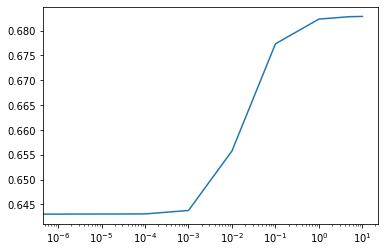

In [90]:
plt.plot(r_to_rmse_dict.keys(), r_to_rmse_dict.values())
plt.semilogx()

The regularization factor `r` that leads to the best score (lowest RMSE) is `0`.

### Question 5

In [102]:
random_seed_to_rmse_dict = dict()
for random_seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_train_val_test_data(df, random_seed=random_seed)
    X_train_0, X_val_0, X_test_0 = fill_na_with_0(X_train, X_val, X_test)
    model_0 = linear_model.LinearRegression()
    model_0.fit(X_train_0, y_train)
    y_val_pred_0 = model_0.predict(X_val_0)
    mse_0 = mean_squared_error(y_val, y_val_pred_0)
    random_seed_to_rmse_dict[random_seed] = np.sqrt(mse_0)

In [103]:
random_seed_to_rmse_dict

{0: 0.6549779961064415,
 1: 0.6462523685688221,
 2: 0.6476558177202666,
 3: 0.6375145070239152,
 4: 0.644580908356587,
 5: 0.6305809996278339,
 6: 0.6297851917331108,
 7: 0.6506184266737699,
 8: 0.6489780353397663,
 9: 0.6437565168235851}

In [106]:
rmse_std = np.std(list(random_seed_to_rmse_dict.values()))
rmse_std

0.00793296596571349

In [107]:
round(rmse_std, 3)

0.008

The RMSE std rounded to 3 digit is `0.008`.

### Question 6

In [108]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_train_val_test_data(df, random_seed=9)
X_train_0, X_val_0, X_test_0 = fill_na_with_0(X_train, X_val, X_test)

In [109]:
X_train_final = pd.concat([X_train_0, X_val_0])

In [115]:
y_train_final = np.concatenate((y_train, y_val))

In [116]:
w0, w = train_linear_regression_reg(X_train_final, y_train_final, r=0.001)
mse = mean_squared_error(y_test, w0 + X_test_0.dot(w))
rmse = np.sqrt(mse)
rmse

0.6452771348469271

The RMSE on the test dataset is `0.6452771348469271`.